In [1]:
import sys
sys.path.append("..")

import os
import time
import pandas as pd
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.transforms import Compose, Grayscale, ToPILImage, ToTensor, Normalize, CenterCrop

from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.classification import MulticlassPrecision
from torchmetrics.classification import MulticlassRecall
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassROC
from torchmetrics.classification import MulticlassAUROC

from sklearn.model_selection import train_test_split

# Extracción de features y bilateral filter

In [ ]:
original_dataset_dir = './datasets/unfiltered_images'
bilateral_filtered_dataset_dir = './datasets/bilateral_filtered_images'
feature_extracted_dataset_dir = './datasets/feature_extracted_images'

if (not os.path.exists(bilateral_filtered_dataset_dir)):
    os.mkdir(bilateral_filtered_dataset_dir)

if (not os.path.exists(feature_extracted_dataset_dir)):
    os.mkdir(feature_extracted_dataset_dir)

for file_name in os.listdir(original_dataset_dir):
    original_image_path = os.path.join(original_dataset_dir, file_name)
    filtered_image_path = os.path.join(
        bilateral_filtered_dataset_dir, file_name)

    print(filtered_image_path)
    img = cv2.imread(original_image_path)

    bilateral_filtered_image = cv2.bilateralFilter(img, 5, 75, 75)

    cv2.imwrite(filtered_image_path, bilateral_filtered_image)


for file_name in os.listdir(original_dataset_dir):
    original_image_path = os.path.join(original_dataset_dir, file_name)
    feature_extracted_image_path = os.path.join(
        feature_extracted_dataset_dir, file_name)

    print(feature_extracted_image_path)
    img = cv2.imread(original_image_path)

    orb = cv2.ORB_create()
    kp = orb.detect(img, None)

    kp, des = orb.compute(img, kp)

    img2 = cv2.drawKeypoints(img, kp, None, color=(255, 255, 255), flags=0)

    cv2.imwrite(feature_extracted_image_path, img2)

# Carga del set de datos

## Clase para el set de datos

In [2]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, file_names, labels, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.img_labels = labels
        self.file_names = file_names
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.file_names.iloc[idx])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Directorios

In [3]:
dataset_path = './datasets/covid-19-radiography-dataset.csv'
unfiltered_images_path = './datasets/unfiltered_images'
feature_extracted_images_path = './datasets/feature_extracted_images'
bilateral_filtered_images_path = './datasets/bilateral_filtered_images'

dataset = pd.read_csv(dataset_path)
dataset_file_names = dataset['file_name']
dataset_labels = dataset['label']

dataset.head()

,file_name,label
0,COVID-1.png,0
1,COVID-10.png,0
2,COVID-100.png,0
3,COVID-1000.png,0
4,COVID-1001.png,0


## Distribución de las clases en el set de datos

In [4]:
class_ids = {
    0: 'covid',
    1: 'lung_opacity',
    2: 'normal',
    3: 'viral_pneumonia'
}

def count_dataset_classes(labels, class_ids):
    class_count = {
        'covid': 0,
        'lung_opacity': 0,
        'normal': 0,
        'viral_pneumonia': 0
    }
    
    for label in labels:
        class_id = class_ids[label]
        class_count[class_id] += 1
    
    return class_count

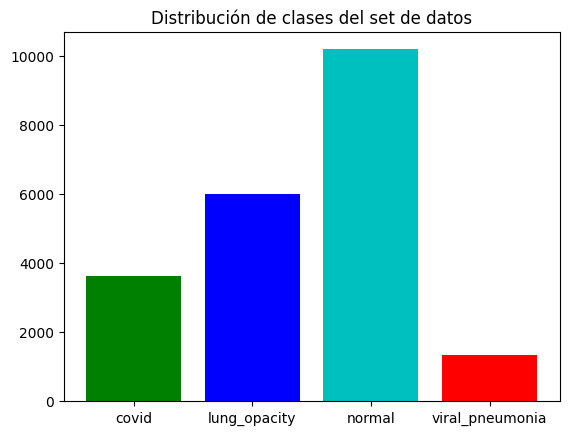

In [5]:
dataset_class_count = count_dataset_classes(dataset_labels, class_ids)

fig, ax = plt.subplots()
ax.set_title('Distribución de clases del set de datos')
ax.bar(list(dataset_class_count.keys()), list(dataset_class_count.values()), color=['g', 'b', 'c', 'r'])

plt.show()

## División del set de datos

Train set distribution:  {'covid': 2893, 'lung_opacity': 4809, 'normal': 8154, 'viral_pneumonia': 1076}
Test set distribution:  {'covid': 723, 'lung_opacity': 1203, 'normal': 2038, 'viral_pneumonia': 269}
Test vs Train distribution:  {'covid': 0.19994469026548672, 'lung_opacity': 0.2000998003992016, 'normal': 0.1999607535321821, 'viral_pneumonia': 0.2}


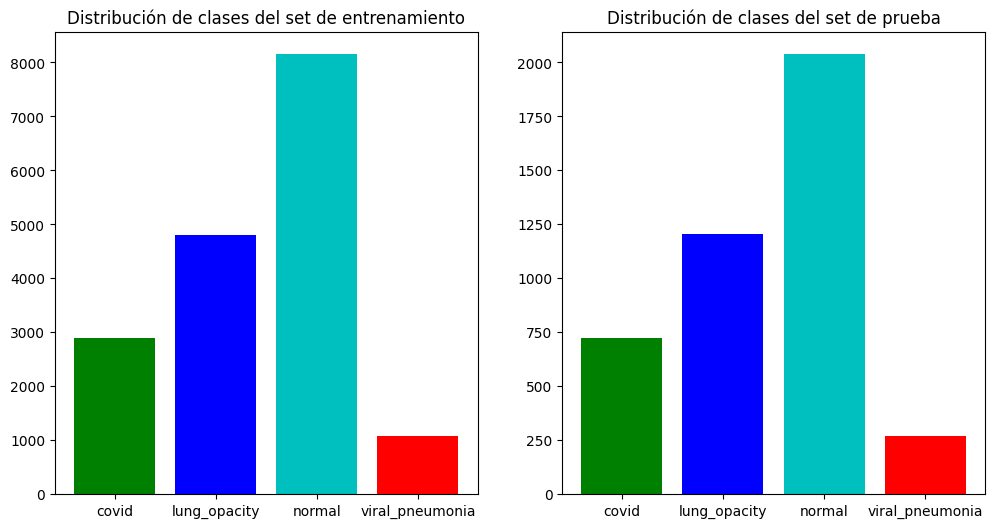

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset_file_names, dataset_labels, test_size=0.2, random_state=404, stratify=dataset_labels)

train_class_count = count_dataset_classes(y_train, class_ids)
test_class_count = count_dataset_classes(y_test, class_ids)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title('Distribución de clases del set de entrenamiento')
ax[0].bar(list(train_class_count.keys()), list(train_class_count.values()), color=['g', 'b', 'c', 'r'])

ax[1].set_title('Distribución de clases del set de prueba')
ax[1].bar(list(test_class_count.keys()), list(test_class_count.values()), color=['g', 'b', 'c', 'r'])

print('Train set distribution: ', train_class_count)
print('Test set distribution: ', test_class_count)
print('Test vs Train distribution: ', {k: test_class_count[k] / (dataset_class_count[k]) for k in test_class_count})
plt.show()

## Uso de GPU si está disponible

In [7]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


# Métricas de evaluación

## Definición de métricas

In [8]:
train_accuracy = MulticlassAccuracy(num_classes=4, average=None).to(device)
test_accuracy = MulticlassAccuracy(num_classes=4, average=None).to(device)

train_precision = MulticlassPrecision(num_classes=4, average=None).to(device)
test_precision = MulticlassPrecision(num_classes=4, average=None).to(device)

train_recall = MulticlassRecall(num_classes=4, average=None).to(device)
test_recall = MulticlassRecall(num_classes=4, average=None).to(device)

train_f1 = MulticlassF1Score(num_classes=4, average=None).to(device)
test_f1 = MulticlassF1Score(num_classes=4, average=None).to(device)

train_roc = MulticlassROC(num_classes=4).to(device)
test_roc = MulticlassROC(num_classes=4).to(device)

train_auroc = MulticlassAUROC(num_classes=4).to(device)
test_auroc = MulticlassAUROC(num_classes=4).to(device)

## Cálculo de métricas

In [9]:
def compute_metrics(train_list, test_list, train_loss, test_loss):
    train_list.append({'loss': train_loss,
                       'accuracy': train_accuracy.compute(),
                       'precision': train_precision.compute(), 
                       'recall': train_recall.compute(),
                       'f1': train_f1.compute(),
                       'roc': train_roc.compute(),
                       'auroc': train_auroc.compute()})
    
    test_list.append({'loss': test_loss,
                      'accuracy': test_accuracy.compute(),
                      'precision': test_precision.compute(),
                      'recall': test_recall.compute(),
                      'f1': test_f1.compute(),
                      'roc': test_roc.compute(),
                      'auroc': test_auroc.compute()})
    
    train_accuracy.reset()
    train_precision.reset()
    train_recall.reset()
    train_f1.reset()
    train_roc.reset()
    train_auroc.reset()
    
    test_accuracy.reset()
    test_precision.reset()
    test_recall.reset()
    test_f1.reset()
    test_roc.reset()
    test_auroc.reset()

## Tablas de las métricas

In [10]:
def show_accuracy_table(train_accuracies, test_accuracies, epochs):
    accuracy_df = pd.DataFrame({
        'Covid Train Accuracy': [train_accuracies[i][0].item() for i in range(epochs)],
        'Covid Test Accuracy': [test_accuracies[i][0].item() for i in range(epochs)],
        
        'Lung-Opacity Train Accuracy': [train_accuracies[i][1].item() for i in range(epochs)],
        'Lung-Opacity Test Accuracy': [test_accuracies[i][1].item() for i in range(epochs)],
        
        'Normal Train Accuracy': [train_accuracies[i][2].item() for i in range(epochs)],
        'Normal Test Accuracy': [test_accuracies[i][2].item() for i in range(epochs)],
        
        'Pneumonia Train Accuracy': [train_accuracies[i][3].item() for i in range(epochs)],
        'Pneumonia Test Accuracy': [test_accuracies[i][3].item() for i in range(epochs)]
    }, index=[epoch+1 for epoch in range(epochs)])

    accuracy_df.index.name = 'Epoch'
    display(accuracy_df)

In [11]:
def show_precision_table(train_precisions, test_precisions, epochs):
    precision_df = pd.DataFrame({
        'Covid Train Precision': [train_precisions[i][0].item() for i in range(epochs)],
        'Covid Test Precision': [test_precisions[i][0].item() for i in range(epochs)],
        
        'Lung-Opacity Train Precision': [train_precisions[i][1].item() for i in range(epochs)],
        'Lung-Opacity Test Precision': [test_precisions[i][1].item() for i in range(epochs)],
        
        'Normal Train Precision': [train_precisions[i][2].item() for i in range(epochs)],
        'Normal Test Precision': [test_precisions[i][2].item() for i in range(epochs)],
        
        'Pneumonia Train Precision': [train_precisions[i][3].item() for i in range(epochs)],
        'Pneumonia Test Precision': [test_precisions[i][3].item() for i in range(epochs)]
    }, index=[epoch+1 for epoch in range(epochs)])

    precision_df.index.name = 'Epoch'
    display(precision_df)

In [12]:
def show_recall_table(train_recalls, test_recalls, epochs):
    recall_df = pd.DataFrame({
        'Covid Train Recall': [train_recalls[i][0].item() for i in range(epochs)],
        'Covid Test Recall': [test_recalls[i][0].item() for i in range(epochs)],
        
        'Lung-Opacity Train Recall': [train_recalls[i][1].item() for i in range(epochs)],
        'Lung-Opacity Test Recall': [test_recalls[i][1].item() for i in range(epochs)],
        
        'Normal Train Recall': [train_recalls[i][2].item() for i in range(epochs)],
        'Normal Test Recall': [test_recalls[i][2].item() for i in range(epochs)],
        
        'Pneumonia Train Recall': [train_recalls[i][3].item() for i in range(epochs)],
        'Pneumonia Test Recall': [test_recalls[i][3].item() for i in range(epochs)]
    }, index=[epoch+1 for epoch in range(epochs)])

    recall_df.index.name = 'Epoch'
    display(recall_df)

In [13]:
def show_f1_score_table(train_f1_scores, test_f1_scores, epochs):
    f1_score_df = pd.DataFrame({
        'Covid Train F1-Score': [train_f1_scores[i][0].item() for i in range(epochs)],
        'Covid Test F1-Score': [test_f1_scores[i][0].item() for i in range(epochs)],
        
        'Lung-Opacity Train F1-Score': [train_f1_scores[i][1].item() for i in range(epochs)],
        'Lung-Opacity Test F1-Score': [test_f1_scores[i][1].item() for i in range(epochs)],
        
        'Normal Train F1-Score': [train_f1_scores[i][2].item() for i in range(epochs)],
        'Normal Test F1-Score': [test_f1_scores[i][2].item() for i in range(epochs)],
        
        'Pneumonia Train F1-Score': [train_f1_scores[i][3].item() for i in range(epochs)],
        'Pneumonia Test F1-Score': [test_f1_scores[i][3].item() for i in range(epochs)]
    }, index=[epoch+1 for epoch in range(epochs)])
    
    f1_score_df.index.name = 'Epoch'
    display(f1_score_df) 

In [14]:
def show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    ax[0, 0].set_title('ROC Curve for Covid')
    ax[0, 0].set_ylabel('TPR')
    ax[0, 0].set_xlabel('FPR')

    ax[0, 1].set_title('ROC Curve for Lung Opacity')
    ax[0, 1].set_ylabel('TPR')
    ax[0, 1].set_xlabel('FPR')

    ax[1, 0].set_title('ROC Curve for Normal')
    ax[1, 0].set_ylabel('TPR')
    ax[1, 0].set_xlabel('FPR')

    ax[1, 1].set_title('ROC Curve for Pneumonia')
    ax[1, 1].set_ylabel('TPR')
    ax[1, 1].set_xlabel('FPR')

    ax[0, 0].plot(train_roc_fpr[0], train_roc_tpr[0], label='Train', color='b')
    ax[0, 0].plot(test_roc_fpr[0], test_roc_tpr[0], label='Test', color='g')

    ax[0, 1].plot(train_roc_fpr[1], train_roc_tpr[1], label='Train', color='b')
    ax[0, 1].plot(test_roc_fpr[1], test_roc_tpr[1], label='Test', color='g')

    ax[1, 0].plot(train_roc_fpr[2], train_roc_tpr[2], label='Train', color='b')
    ax[1, 0].plot(test_roc_fpr[2], test_roc_tpr[2], label='Test', color='g')

    ax[1, 1].plot(train_roc_fpr[3], train_roc_tpr[3], label='Train', color='b')
    ax[1, 1].plot(test_roc_fpr[3], test_roc_tpr[3], label='Test', color='g')

    ax[0, 0].legend()
    ax[0, 1].legend()
    ax[1, 0].legend()
    ax[1, 1].legend()
    fig.show()

In [15]:
def show_learning_curve(train_losses, test_losses, epoch_list):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title('Loss vs Epoch')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_xticks(epoch_list)

    ax.plot(epoch_list, train_losses, label='Train', color='b', marker='o')
    ax.plot(epoch_list, test_losses, label='Test', color='g', marker='o')

    ax.legend()
    fig.show()

# Función de entrenamiento

In [16]:
def train(dataloader, model, loss_fn, optimizer):
    print('--------------------------- Training --------------------------\n')
    size = len(dataloader.dataset)
    loss = torch.Tensor([0]).to(device)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        
        train_accuracy.update(pred, y)
        train_precision.update(pred, y)
        train_recall.update(pred, y)
        train_f1.update(pred, y)    
        train_roc.update(pred, y)
        train_auroc.update(pred, y)
        
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f'Current Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')
    
    return loss.item()

# Función de evaluación

In [17]:
def test(dataloader, model, loss_fn):
    print('--------------------------- Testing ---------------------------\n')
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            
            test_accuracy.update(pred, y)
            test_precision.update(pred, y)
            test_recall.update(pred, y)
            test_f1.update(pred, y)    
            test_roc.update(pred, y)
            test_auroc.update(pred, y)
            
            test_loss += loss_fn(pred, y).item()
            
    test_loss /= num_batches
    accuracy_df = pd.DataFrame({
        'Covid Test Accuracy': [test_accuracy.compute()[0].item()],
        'Lung-Opacity Test Opacity Accuracy': [test_accuracy.compute()[1].item()],
        'Normal Test Accuracy': [test_accuracy.compute()[2].item()],
        'Pneumonia Test Accuracy': [test_accuracy.compute()[3].item()]
    })
    display(accuracy_df)
    return test_loss

# Modelo 1 - MLP básica
## Sin Feature Extractor

## Arquitectura del modelo

In [18]:
class MLP_basic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP_basic, self).__init__()
        # Capa de entrada
        self.fc1 = nn.Linear(input_size, hidden_size) 
        # Capa de salida 
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        # Función de activación ReLU en la capa oculta
        x = torch.relu(self.fc1(x))  
        # Sin función de activación en la capa de salida
        x = self.fc2(x)  
        return x

## Feature Engineering

In [52]:
unfiltered_train_dataset = CustomDataset(unfiltered_images_path, X_train, y_train, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    CenterCrop(250),
    Normalize(0.5, 0.5)
]))

unfiltered_test_dataset = CustomDataset(unfiltered_images_path, X_test, y_test, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    CenterCrop(250),
    Normalize(0.5, 0.5)
]))

## Entrenamiento del modelo

In [41]:
batch_size = 32
learning_rate = 1e-5
momentum = 0.9
epochs = 1

unfiltered_basic_mlp_model = MLP_basic(250*250, 128, 4).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unfiltered_basic_mlp_model.parameters(), lr=learning_rate, momentum=momentum)

unfiltered_train_dataloader = DataLoader(
    unfiltered_train_dataset, batch_size=batch_size, shuffle=True)

unfiltered_test_dataloader = DataLoader(
    unfiltered_test_dataset, batch_size=batch_size, shuffle=True)

In [42]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(unfiltered_train_dataloader, unfiltered_basic_mlp_model, loss_fn, optimizer)
    test_loss = test(unfiltered_test_dataloader, unfiltered_basic_mlp_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.462560  [   32/16932]
Current Loss: 1.420447  [  352/16932]
Current Loss: 1.354450  [  672/16932]
Current Loss: 1.297106  [  992/16932]
Current Loss: 1.315572  [ 1312/16932]
Current Loss: 1.156954  [ 1632/16932]
Current Loss: 1.174219  [ 1952/16932]
Current Loss: 1.209065  [ 2272/16932]
Current Loss: 1.099652  [ 2592/16932]
Current Loss: 1.167542  [ 2912/16932]
Current Loss: 1.200710  [ 3232/16932]
Current Loss: 1.092399  [ 3552/16932]
Current Loss: 1.092315  [ 3872/16932]
Current Loss: 1.185826  [ 4192/16932]
Current Loss: 0.985329  [ 4512/16932]
Current Loss: 0.959078  [ 4832/16932]
Current Loss: 0.999196  [ 5152/16932]
Current Loss: 0.990921  [ 5472/16932]
Current Loss: 1.095049  [ 5792/16932]
Current Loss: 0.951798  [ 6112/16932]
Current Loss: 0.926476  [ 6432/16932]
Current Loss: 1.087908  [ 6752/16932]
Current Loss: 0.926187  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.041494,0.661679,0.905299,0.141264


Training time: 5.965 minutes


## Evaluación del modelo

### Curva de entrenamiento

/tmp/ipykernel_43406/1119352215.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


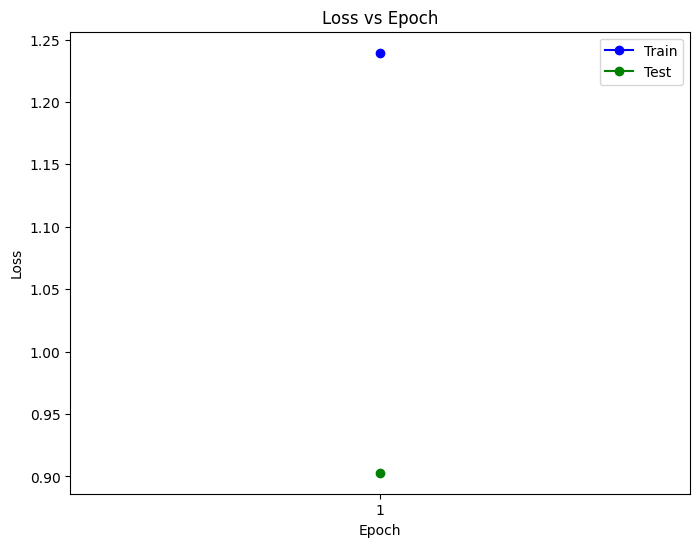

In [43]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [44]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

,Covid Train Accuracy,Covid Test Accuracy,Lung-Opacity Train Opacity Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Train Accuracy,Normal Test Accuracy,Pneumonia Train Accuracy,Pneumonia Test Accuracy
Epoch,,,,,,,,
1,0.066713,0.041494,0.482429,0.661679,0.886191,0.905299,0.015799,0.141264


### Precision

In [45]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

,Covid Train Precision,Covid Test Precision,Lung-Opacity Train Opacity Precision,Lung-Opacity Test Opacity Precision,Normal Train Precision,Normal Test Precision,Pneumonia Train Precision,Pneumonia Test Precision
Epoch,,,,,,,,
1,0.252618,0.441176,0.588832,0.60717,0.594341,0.658223,0.242857,0.745098


### Recall

In [46]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

,Covid Train Recall,Covid Test Recall,Lung-Opacity Train Opacity Recall,Lung-Opacity Test Opacity Recall,Normal Train Recall,Normal Test Recall,Pneumonia Train Recall,Pneumonia Test Recall
Epoch,,,,,,,,
1,0.066713,0.041494,0.482429,0.661679,0.886191,0.905299,0.015799,0.141264


### F1-Score

In [47]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

,Covid Train F1-Score,Covid Test F1-Score,Lung-Opacity Train Opacity F1-Score,Lung-Opacity Test Opacity F1-Score,Normal Train F1-Score,Normal Test F1-Score,Pneumonia Train F1-Score,Pneumonia Test F1-Score
Epoch,,,,,,,,
1,0.105551,0.075853,0.530346,0.633254,0.711501,0.762239,0.029668,0.2375


### Gráfico ROC para cada clase

/tmp/ipykernel_43406/2518052900.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


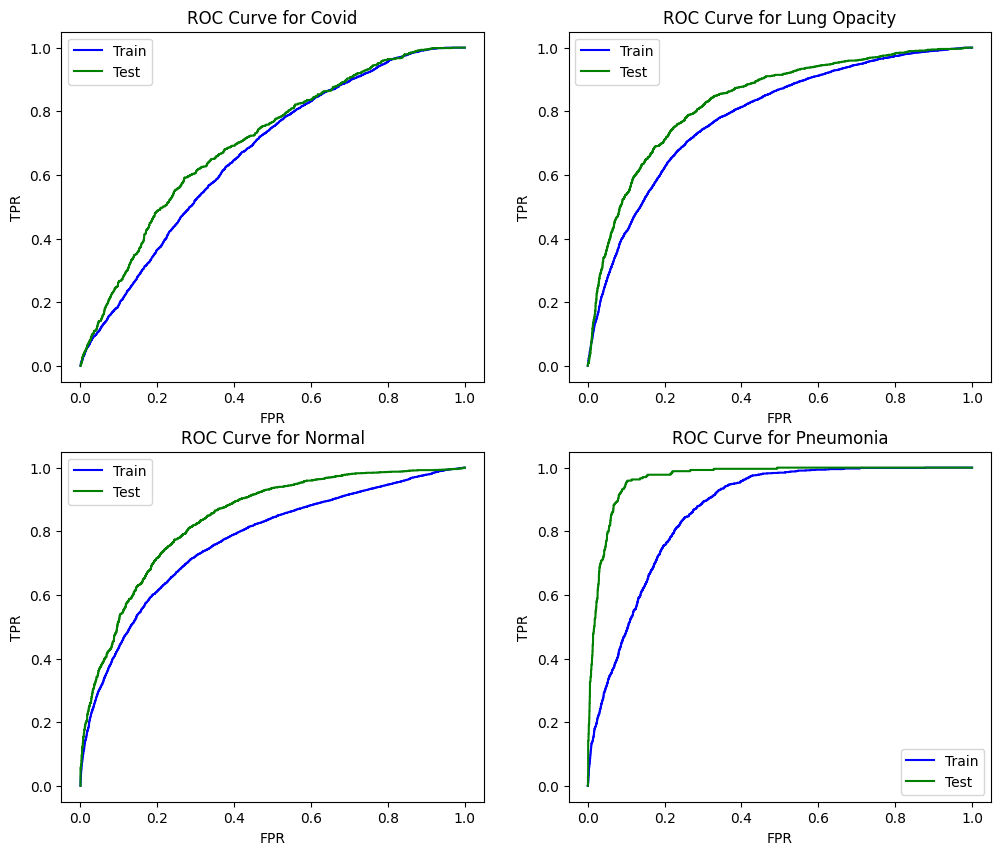

In [48]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Modelo 1 - MLP básica
## Con Feature Extractor

## Feature Engineering

In [19]:
feature_extracted_train_dataset = CustomDataset(feature_extracted_images_path, X_train, y_train, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    CenterCrop(250),
    Normalize(0.5, 0.5)
]))

feature_extracted_test_dataset = CustomDataset(feature_extracted_images_path, X_test, y_test, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    CenterCrop(250),
    Normalize(0.5, 0.5)
]))

## Entrenamiento del modelo

In [20]:
batch_size = 32
learning_rate = 1e-5
momentum = 0.9
epochs = 1

feature_extracted_basic_mlp_model = MLP_basic(250*250, 128, 4).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(feature_extracted_basic_mlp_model.parameters(), lr=learning_rate, momentum=momentum)

feature_extracted_train_dataloader = DataLoader(
    feature_extracted_train_dataset, batch_size=batch_size, shuffle=True)

feature_extracted_test_dataloader = DataLoader(
    feature_extracted_test_dataset, batch_size=batch_size, shuffle=True)

In [21]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(feature_extracted_train_dataloader, feature_extracted_basic_mlp_model, loss_fn, optimizer)
    test_loss = test(feature_extracted_test_dataloader, feature_extracted_basic_mlp_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.362980  [   32/16932]
Current Loss: 1.349608  [  352/16932]
Current Loss: 1.307253  [  672/16932]
Current Loss: 1.281340  [  992/16932]
Current Loss: 1.247357  [ 1312/16932]
Current Loss: 1.191286  [ 1632/16932]
Current Loss: 1.163514  [ 1952/16932]
Current Loss: 1.256425  [ 2272/16932]
Current Loss: 1.032270  [ 2592/16932]
Current Loss: 1.190094  [ 2912/16932]
Current Loss: 0.980401  [ 3232/16932]
Current Loss: 0.988725  [ 3552/16932]
Current Loss: 0.961108  [ 3872/16932]
Current Loss: 0.999602  [ 4192/16932]
Current Loss: 1.044198  [ 4512/16932]
Current Loss: 1.063090  [ 4832/16932]
Current Loss: 1.054673  [ 5152/16932]
Current Loss: 1.042473  [ 5472/16932]
Current Loss: 1.060060  [ 5792/16932]
Current Loss: 1.233146  [ 6112/16932]
Current Loss: 0.885618  [ 6432/16932]
Current Loss: 0.949548  [ 6752/16932]
Current Loss: 1.060959  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.052559,0.57606,0.91315,0.211896


Training time: 3.765 minutes


## Evaluación del modelo

### Curva de entrenamiento

In [ ]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [ ]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

### Precision

In [ ]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

### Recall

In [ ]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

### F1-Score

In [ ]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

### Gráfico ROC para cada clase

In [ ]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Modelo 2 - MLP con capas ocultas múltiples
## Sin Feature Extractor

## Arquitectura del modelo

In [53]:
class MLP_hiddenLayers(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP_hiddenLayers, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        # Capa de entrada
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.hidden_layers = nn.ModuleList()

        # Capas ocultas
        for i in range(len(hidden_sizes) - 1):
            hidden_layer = nn.Linear(hidden_sizes[i], hidden_sizes[i+1])
            self.hidden_layers.append(hidden_layer)

        # Capa de salida
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = torch.relu(hidden_layer(x))
        x = self.output_layer(x)
        return x


## Entrenamiento del modelo

In [54]:
batch_size = 32
learning_rate = 1e-5
momentum = 0.2
epochs = 1

#InputSize = tamaño de las imagenes
#HiddenSize = capa oculta
#OutputSize = capa de salida (labels del 0 al 3)
unfiltered_hidden_layers_mlp_model = MLP_hiddenLayers(250*250, [512, 256], 4).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unfiltered_hidden_layers_mlp_model.parameters(), lr=learning_rate, momentum=momentum)

unfiltered_train_dataloader = DataLoader(
    unfiltered_train_dataset, batch_size=batch_size, shuffle=True)

unfiltered_test_dataloader = DataLoader(
    unfiltered_test_dataset, batch_size=batch_size, shuffle=True)

In [55]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(unfiltered_train_dataloader, unfiltered_hidden_layers_mlp_model, loss_fn, optimizer)
    test_loss = test(unfiltered_test_dataloader, unfiltered_hidden_layers_mlp_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.383871  [   32/16932]
Current Loss: 1.388471  [  352/16932]
Current Loss: 1.372216  [  672/16932]
Current Loss: 1.370884  [  992/16932]
Current Loss: 1.366723  [ 1312/16932]
Current Loss: 1.357084  [ 1632/16932]
Current Loss: 1.361655  [ 1952/16932]
Current Loss: 1.356741  [ 2272/16932]
Current Loss: 1.334261  [ 2592/16932]
Current Loss: 1.322588  [ 2912/16932]
Current Loss: 1.319860  [ 3232/16932]
Current Loss: 1.343486  [ 3552/16932]
Current Loss: 1.293899  [ 3872/16932]
Current Loss: 1.281559  [ 4192/16932]
Current Loss: 1.300590  [ 4512/16932]
Current Loss: 1.317349  [ 4832/16932]
Current Loss: 1.293201  [ 5152/16932]
Current Loss: 1.235334  [ 5472/16932]
Current Loss: 1.294623  [ 5792/16932]
Current Loss: 1.257353  [ 6112/16932]
Current Loss: 1.305660  [ 6432/16932]
Current Loss: 1.264091  [ 6752/16932]
Current Loss: 1.235709  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.011065,0.092269,0.992149,0.0


Training time: 7.875 minutes


## Evaluación del modelo

### Curva de entrenamiento

/tmp/ipykernel_43406/1119352215.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


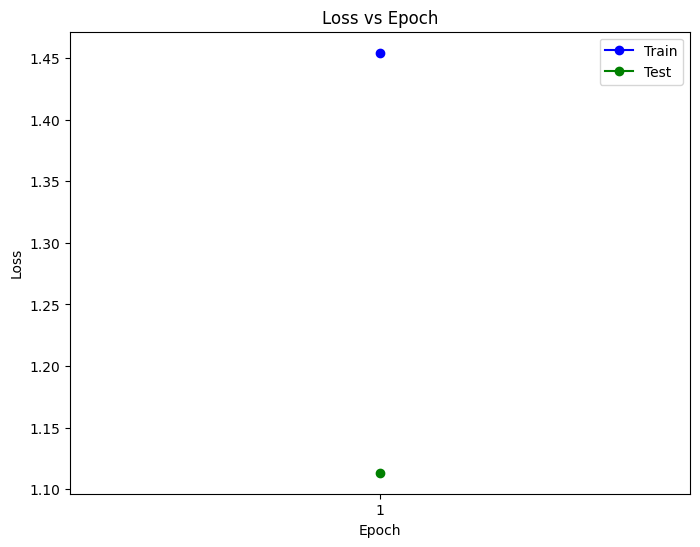

In [56]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [57]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

,Covid Train Accuracy,Covid Test Accuracy,Lung-Opacity Train Opacity Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Train Accuracy,Normal Test Accuracy,Pneumonia Train Accuracy,Pneumonia Test Accuracy
Epoch,,,,,,,,
1,0.136191,0.011065,0.058848,0.092269,0.872823,0.992149,0.0,0.0


### Precision

In [58]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

,Covid Train Precision,Covid Test Precision,Lung-Opacity Train Opacity Precision,Lung-Opacity Test Opacity Precision,Normal Train Precision,Normal Test Precision,Pneumonia Train Precision,Pneumonia Test Precision
Epoch,,,,,,,,
1,0.183171,0.444444,0.545279,0.627119,0.499123,0.501115,0.0,0.0


### Recall

In [59]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

,Covid Train Recall,Covid Test Recall,Lung-Opacity Train Opacity Recall,Lung-Opacity Test Opacity Recall,Normal Train Recall,Normal Test Recall,Pneumonia Train Recall,Pneumonia Test Recall
Epoch,,,,,,,,
1,0.136191,0.011065,0.058848,0.092269,0.872823,0.992149,0.0,0.0


### F1-Score

In [60]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

,Covid Train F1-Score,Covid Test F1-Score,Lung-Opacity Train Opacity F1-Score,Lung-Opacity Test Opacity F1-Score,Normal Train F1-Score,Normal Test F1-Score,Pneumonia Train F1-Score,Pneumonia Test F1-Score
Epoch,,,,,,,,
1,0.156225,0.021592,0.106231,0.16087,0.635078,0.665898,0.0,0.0


### Gráfico ROC para cada clase

/tmp/ipykernel_43406/2518052900.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


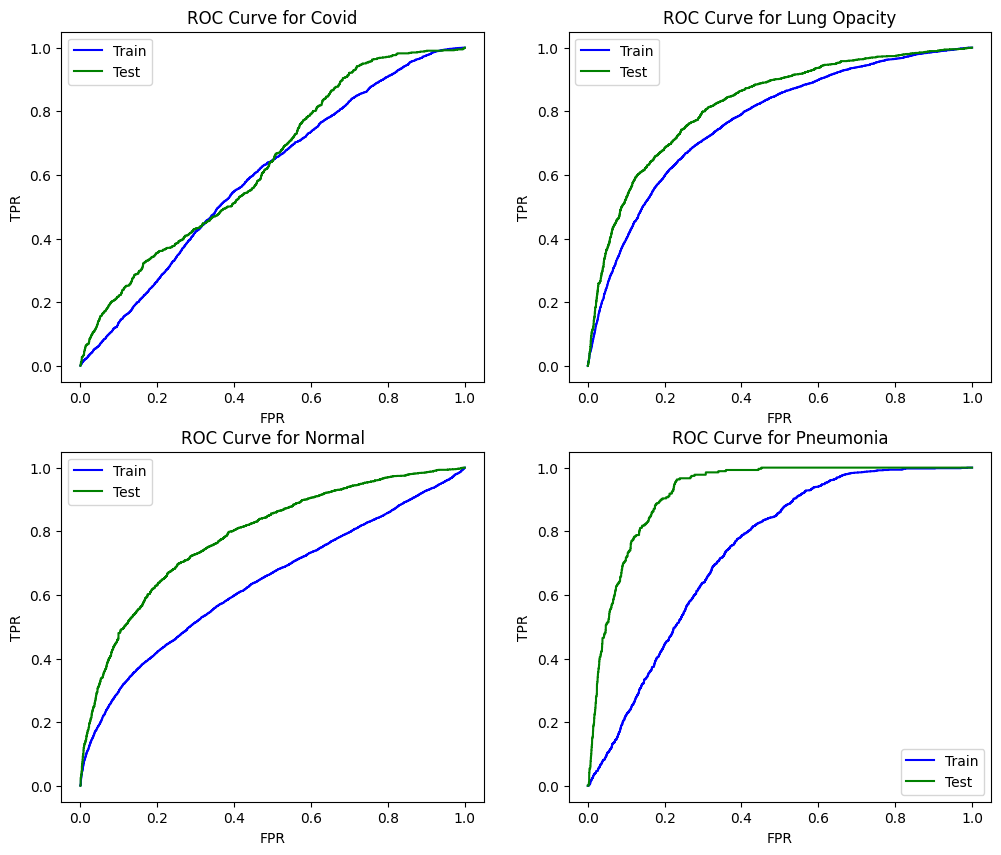

In [61]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Modelo 2 - MLP con múltiples capas ocultas
## Con Feature Extractor

## Entrenamiento del modelo

In [ ]:
batch_size = 32
learning_rate = 1e-5
momentum = 0.2
epochs = 1

feature_extracted_hidden_layers_mlp_model = MLP_hiddenLayers(250*250, [512, 256], 4).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(feature_extracted_hidden_layers_mlp_model.parameters(), lr=learning_rate, momentum=momentum)

feature_extracted_train_dataloader = DataLoader(
    feature_extracted_train_dataset, batch_size=batch_size, shuffle=True)

feature_extracted_test_dataloader = DataLoader(
    feature_extracted_test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(feature_extracted_train_dataloader, feature_extracted_hidden_layers_mlp_model, loss_fn, optimizer)
    test_loss = test(feature_extracted_test_dataloader, feature_extracted_hidden_layers_mlp_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.462560  [   32/16932]
Current Loss: 1.420447  [  352/16932]
Current Loss: 1.354450  [  672/16932]
Current Loss: 1.297106  [  992/16932]
Current Loss: 1.315572  [ 1312/16932]
Current Loss: 1.156954  [ 1632/16932]
Current Loss: 1.174219  [ 1952/16932]
Current Loss: 1.209065  [ 2272/16932]
Current Loss: 1.099652  [ 2592/16932]
Current Loss: 1.167542  [ 2912/16932]
Current Loss: 1.200710  [ 3232/16932]
Current Loss: 1.092399  [ 3552/16932]
Current Loss: 1.092315  [ 3872/16932]
Current Loss: 1.185826  [ 4192/16932]
Current Loss: 0.985329  [ 4512/16932]
Current Loss: 0.959078  [ 4832/16932]
Current Loss: 0.999196  [ 5152/16932]
Current Loss: 0.990921  [ 5472/16932]
Current Loss: 1.095049  [ 5792/16932]
Current Loss: 0.951798  [ 6112/16932]
Current Loss: 0.926476  [ 6432/16932]
Current Loss: 1.087908  [ 6752/16932]
Current Loss: 0.926187  [ 7072/169

## Evaluación del modelo

### Curva de entrenamiento

In [ ]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [ ]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

### Precision

In [ ]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

### Recall

In [ ]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

### F1-Score

In [ ]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

### Gráfico ROC para cada clase

In [ ]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Modelo 3 - MLP con regularización
## Sin Feature Extractor

## Arquitectura del modelo

In [70]:
class MLP_reg(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.5, weight_decay=0.01):
        super(MLP_reg, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.dropout_rate = dropout_rate
        self.weight_decay = weight_decay

        # Capa de entrada
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.hidden_layers = nn.ModuleList()

        # Capas ocultas
        for i in range(len(hidden_sizes) - 1):
            hidden_layer = nn.Linear(hidden_sizes[i], hidden_sizes[i+1])
            self.hidden_layers.append(hidden_layer)

        # Capa de salida
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

        # Regularización L2
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = torch.relu(hidden_layer(x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

    def calculate_l2_loss(self):
        l2_loss = torch.tensor(0., requires_grad=True)
        for param in self.parameters():
            l2_loss += torch.norm(param, p=2)
        return l2_loss * self.weight_decay

## Entrenamiento del modelo

In [71]:
batch_size = 32
learning_rate = 1e-5
momentum = 0.2
epochs = 1

unfiltered_reg_mlp_model = MLP_reg(250*250, [512, 256], 4, 0.5, 0.01) .to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unfiltered_reg_mlp_model.parameters(), lr=learning_rate, momentum=momentum)

unfiltered_train_dataloader = DataLoader(
    unfiltered_train_dataset, batch_size=batch_size, shuffle=True)

unfiltered_test_dataloader = DataLoader(
    unfiltered_test_dataset, batch_size=batch_size, shuffle=True)

In [72]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(unfiltered_train_dataloader, unfiltered_reg_mlp_model, loss_fn, optimizer)
    test_loss = test(unfiltered_test_dataloader, unfiltered_reg_mlp_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.389007  [   32/16932]
Current Loss: 1.404002  [  352/16932]
Current Loss: 1.382607  [  672/16932]
Current Loss: 1.368923  [  992/16932]
Current Loss: 1.361198  [ 1312/16932]
Current Loss: 1.360616  [ 1632/16932]
Current Loss: 1.364104  [ 1952/16932]
Current Loss: 1.370644  [ 2272/16932]
Current Loss: 1.343732  [ 2592/16932]
Current Loss: 1.315520  [ 2912/16932]
Current Loss: 1.339810  [ 3232/16932]
Current Loss: 1.331434  [ 3552/16932]
Current Loss: 1.290970  [ 3872/16932]
Current Loss: 1.332328  [ 4192/16932]
Current Loss: 1.330283  [ 4512/16932]
Current Loss: 1.324831  [ 4832/16932]
Current Loss: 1.301175  [ 5152/16932]
Current Loss: 1.271263  [ 5472/16932]
Current Loss: 1.262941  [ 5792/16932]
Current Loss: 1.323381  [ 6112/16932]
Current Loss: 1.235812  [ 6432/16932]
Current Loss: 1.297093  [ 6752/16932]
Current Loss: 1.277250  [ 7072/169

,Covid Test Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Test Accuracy,Pneumonia Test Accuracy
0,0.011065,0.022444,0.996075,0.003717


Training time: 7.396 minutes


## Evaluación del modelo

### Curva de entrenamiento

/tmp/ipykernel_43406/1119352215.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


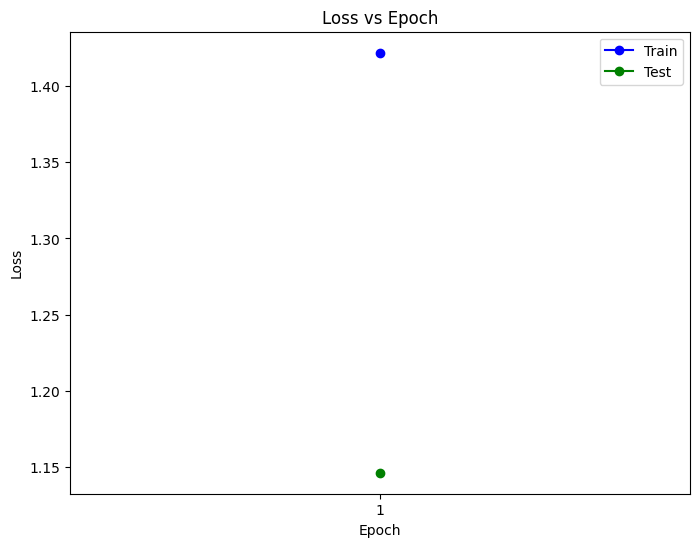

In [73]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [74]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

,Covid Train Accuracy,Covid Test Accuracy,Lung-Opacity Train Opacity Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Train Accuracy,Normal Test Accuracy,Pneumonia Train Accuracy,Pneumonia Test Accuracy
Epoch,,,,,,,,
1,0.076391,0.011065,0.016428,0.022444,0.906426,0.996075,0.071561,0.003717


### Precision

In [75]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

,Covid Train Precision,Covid Test Precision,Lung-Opacity Train Opacity Precision,Lung-Opacity Test Opacity Precision,Normal Train Precision,Normal Test Precision,Pneumonia Train Precision,Pneumonia Test Precision
Epoch,,,,,,,,
1,0.203312,0.666667,0.658333,0.658537,0.493325,0.487278,0.103634,0.071429


### Recall

In [76]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

,Covid Train Recall,Covid Test Recall,Lung-Opacity Train Opacity Recall,Lung-Opacity Test Opacity Recall,Normal Train Recall,Normal Test Recall,Pneumonia Train Recall,Pneumonia Test Recall
Epoch,,,,,,,,
1,0.076391,0.011065,0.016428,0.022444,0.906426,0.996075,0.071561,0.003717


### F1-Score

In [77]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

,Covid Train F1-Score,Covid Test F1-Score,Lung-Opacity Train Opacity F1-Score,Lung-Opacity Test Opacity F1-Score,Normal Train F1-Score,Normal Test F1-Score,Pneumonia Train F1-Score,Pneumonia Test F1-Score
Epoch,,,,,,,,
1,0.111055,0.021769,0.032055,0.043408,0.638918,0.654417,0.084662,0.007067


### Gráfico ROC para cada clase

/tmp/ipykernel_43406/2518052900.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


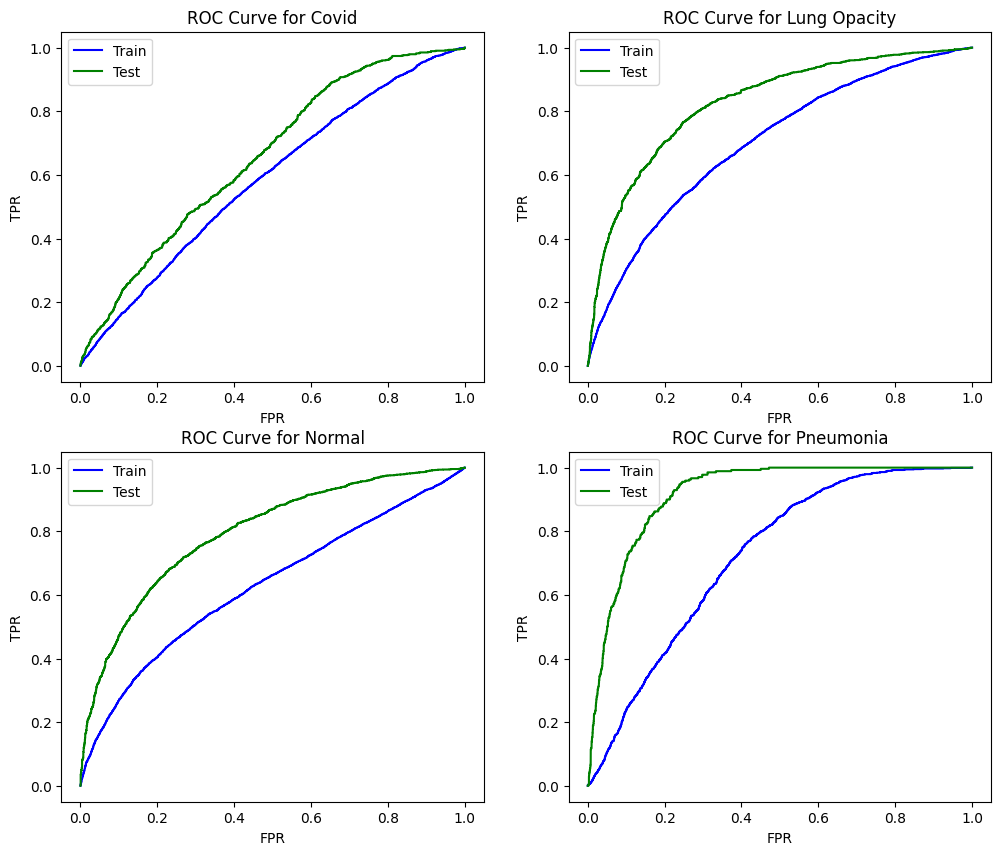

In [78]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Modelo 3 - MLP con regularización
## Con Feature Extractor

## Entrenamiento del modelo

In [ ]:
batch_size = 32
learning_rate = 1e-5
momentum = 0.2
epochs = 1

feature_extracted_reg_mlp_model = MLP_reg(250*250, [512, 256], 4, 0.5, 0.01) .to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(feature_extracted_reg_mlp_model.parameters(), lr=learning_rate, momentum=momentum)

feature_extracted_train_dataloader = DataLoader(
    feature_extracted_train_dataset, batch_size=batch_size, shuffle=True)

feature_extracted_test_dataloader = DataLoader(
    feature_extracted_test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(feature_extracted_train_dataloader, feature_extracted_reg_mlp_model, loss_fn, optimizer)
    test_loss = test(feature_extracted_test_dataloader, feature_extracted_reg_mlp_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.462560  [   32/16932]
Current Loss: 1.420447  [  352/16932]
Current Loss: 1.354450  [  672/16932]
Current Loss: 1.297106  [  992/16932]
Current Loss: 1.315572  [ 1312/16932]
Current Loss: 1.156954  [ 1632/16932]
Current Loss: 1.174219  [ 1952/16932]
Current Loss: 1.209065  [ 2272/16932]
Current Loss: 1.099652  [ 2592/16932]
Current Loss: 1.167542  [ 2912/16932]
Current Loss: 1.200710  [ 3232/16932]
Current Loss: 1.092399  [ 3552/16932]
Current Loss: 1.092315  [ 3872/16932]
Current Loss: 1.185826  [ 4192/16932]
Current Loss: 0.985329  [ 4512/16932]
Current Loss: 0.959078  [ 4832/16932]
Current Loss: 0.999196  [ 5152/16932]
Current Loss: 0.990921  [ 5472/16932]
Current Loss: 1.095049  [ 5792/16932]
Current Loss: 0.951798  [ 6112/16932]
Current Loss: 0.926476  [ 6432/16932]
Current Loss: 1.087908  [ 6752/16932]
Current Loss: 0.926187  [ 7072/169

## Evaluación del modelo

### Curva de entrenamiento

In [ ]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [ ]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

### Precision

In [ ]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

### Recall

In [ ]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

### F1-Score

In [ ]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

### Gráfico ROC para cada clase

In [ ]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Red Convolucional 
## Sin Bilateral Filter

## Arquitectura del modelo

In [58]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Dropout(p=0.3),
            
            nn.Linear(in_features=576, out_features=4096),
            nn.ReLU(),
            
            nn.Linear(in_features=4096, out_features=1000),
            nn.ReLU(),
            
            nn.Linear(in_features=1000, out_features=4)
        )

    def forward(self, x):
        logits = self.sequential(x)
        return logits

## Entrenamiento del modelo

In [63]:
batch_size = 32
learning_rate = 1e-5
momentum = 0
epochs = 10

unfiltered_cnn_model = ConvolutionalNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unfiltered_cnn_model.parameters(), lr=learning_rate, momentum=momentum)

unfiltered_train_dataloader = DataLoader(
    unfiltered_train_dataset, batch_size=batch_size, shuffle=True)

unfiltered_test_dataloader = DataLoader(
    unfiltered_test_dataset, batch_size=batch_size, shuffle=True)

In [64]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(unfiltered_train_dataloader, unfiltered_cnn_model, loss_fn, optimizer)
    test_loss = test(unfiltered_test_dataloader, unfiltered_cnn_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.386273  [   32/16932]
Current Loss: 1.387251  [  352/16932]
Current Loss: 1.384094  [  672/16932]
Current Loss: 1.387212  [  992/16932]
Current Loss: 1.385325  [ 1312/16932]
Current Loss: 1.384782  [ 1632/16932]
Current Loss: 1.385520  [ 1952/16932]
Current Loss: 1.385603  [ 2272/16932]
Current Loss: 1.387297  [ 2592/16932]
Current Loss: 1.385814  [ 2912/16932]
Current Loss: 1.384532  [ 3232/16932]
Current Loss: 1.386927  [ 3552/16932]


KeyboardInterrupt: 

## Evaluación del modelo

### Curva de entrenamiento

/tmp/ipykernel_33546/1119352215.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


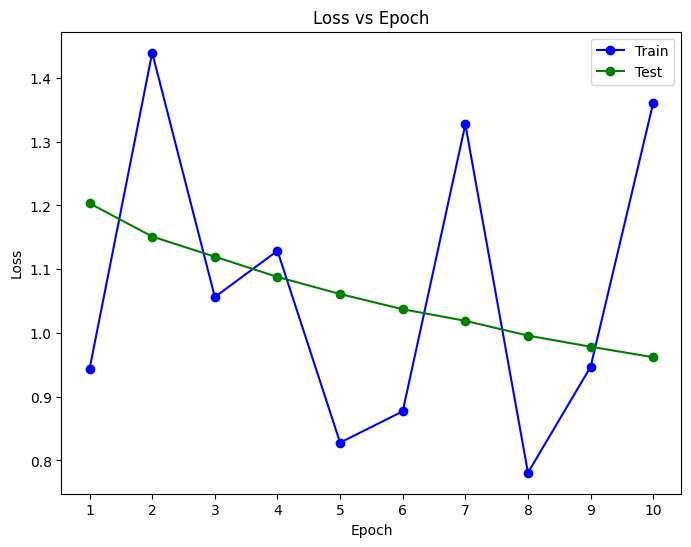

In [ ]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [ ]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

,Covid Train Accuracy,Covid Test Accuracy,Lung-Opacity Train Opacity Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Train Accuracy,Normal Test Accuracy,Pneumonia Train Accuracy,Pneumonia Test Accuracy
Epoch,,,,,,,,
1,0.006222,0.0,0.426284,0.000000,0.596272,1.000000,0.011152,0.0
2,0.000000,0.0,0.003327,0.007481,0.999509,0.998528,0.000000,0.0
3,0.000000,0.0,0.045956,0.073150,0.994849,0.994112,0.000000,0.0
4,0.000000,0.0,0.148472,0.248545,0.987123,0.985280,0.000000,0.0
5,0.000000,0.0,0.309420,0.347465,0.971916,0.979392,0.000000,0.0
6,0.000000,0.0,0.388646,0.448878,0.960878,0.965653,0.000000,0.0
7,0.000000,0.0,0.464546,0.487947,0.947756,0.959764,0.000000,0.0
8,0.000000,0.0,0.510501,0.537822,0.938926,0.946516,0.000000,0.0
9,0.000346,0.0,0.538158,0.581047,0.931322,0.937684,0.000000,0.0


### Precision

In [ ]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

,Covid Train Precision,Covid Test Precision,Lung-Opacity Train Opacity Precision,Lung-Opacity Test Opacity Precision,Normal Train Precision,Normal Test Precision,Pneumonia Train Precision,Pneumonia Test Precision
Epoch,,,,,,,,
1,0.125874,0.0,0.300984,0.000000,0.496173,0.481455,0.067039,0.0
2,0.000000,0.0,0.410256,0.450000,0.482448,0.483029,0.000000,0.0
3,0.000000,0.0,0.580052,0.564103,0.490121,0.496934,0.000000,0.0
4,0.000000,0.0,0.617647,0.667411,0.510205,0.530515,0.000000,0.0
5,0.000000,0.0,0.630776,0.675283,0.543814,0.552297,0.000000,0.0
6,0.000000,0.0,0.624040,0.651387,0.562173,0.578143,0.000000,0.0
7,0.000000,0.0,0.613399,0.633909,0.581490,0.591473,0.000000,0.0
8,0.000000,0.0,0.604978,0.615019,0.594687,0.606413,0.000000,0.0
9,1.000000,0.0,0.599768,0.611549,0.601934,0.618447,0.000000,0.0


### Recall

In [ ]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

,Covid Train Recall,Covid Test Recall,Lung-Opacity Train Opacity Recall,Lung-Opacity Test Opacity Recall,Normal Train Recall,Normal Test Recall,Pneumonia Train Recall,Pneumonia Test Recall
Epoch,,,,,,,,
1,0.006222,0.0,0.426284,0.000000,0.596272,1.000000,0.011152,0.0
2,0.000000,0.0,0.003327,0.007481,0.999509,0.998528,0.000000,0.0
3,0.000000,0.0,0.045956,0.073150,0.994849,0.994112,0.000000,0.0
4,0.000000,0.0,0.148472,0.248545,0.987123,0.985280,0.000000,0.0
5,0.000000,0.0,0.309420,0.347465,0.971916,0.979392,0.000000,0.0
6,0.000000,0.0,0.388646,0.448878,0.960878,0.965653,0.000000,0.0
7,0.000000,0.0,0.464546,0.487947,0.947756,0.959764,0.000000,0.0
8,0.000000,0.0,0.510501,0.537822,0.938926,0.946516,0.000000,0.0
9,0.000346,0.0,0.538158,0.581047,0.931322,0.937684,0.000000,0.0


### F1-Score

In [ ]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

,Covid Train F1-Score,Covid Test F1-Score,Lung-Opacity Train Opacity F1-Score,Lung-Opacity Test Opacity F1-Score,Normal Train F1-Score,Normal Test F1-Score,Pneumonia Train F1-Score,Pneumonia Test F1-Score
Epoch,,,,,,,,
1,0.011858,0.0,0.352840,0.000000,0.541636,0.649976,0.019124,0.0
2,0.000000,0.0,0.006601,0.014718,0.650777,0.651096,0.000000,0.0
3,0.000000,0.0,0.085164,0.129507,0.656709,0.662633,0.000000,0.0
4,0.000000,0.0,0.239396,0.362205,0.672712,0.689679,0.000000,0.0
5,0.000000,0.0,0.415179,0.458836,0.697408,0.706299,0.000000,0.0
6,0.000000,0.0,0.478985,0.531496,0.709339,0.723264,0.000000,0.0
7,0.000000,0.0,0.528695,0.551433,0.720761,0.731899,0.000000,0.0
8,0.000000,0.0,0.553739,0.573836,0.728172,0.739222,0.000000,0.0
9,0.000691,0.0,0.567295,0.595908,0.731247,0.745320,0.000000,0.0


### Gráfico ROC para cada clase

/tmp/ipykernel_33546/2518052900.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


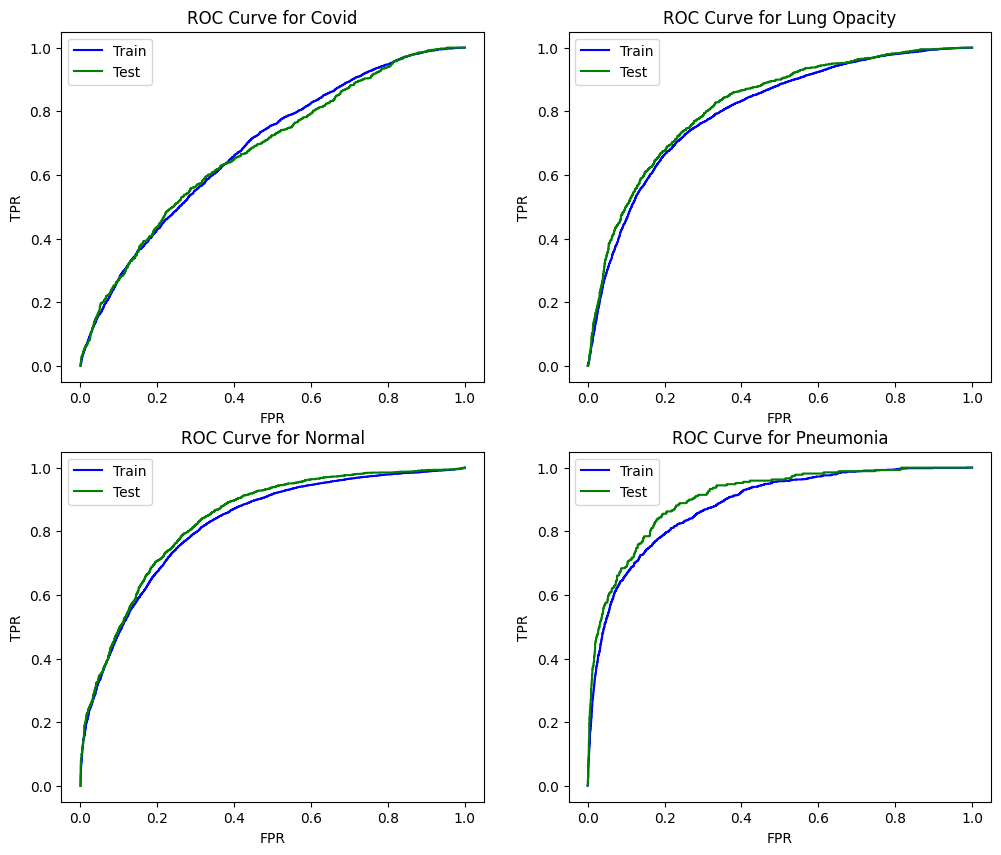

In [ ]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Red Convolucional 
## Con Bilateral Filter

## Feature Engineering

In [48]:
bilateral_filtered_train_dataset = CustomDataset(bilateral_filtered_images_path, X_train, y_train, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    CenterCrop(250),
    Normalize(0.5, 0.5)
]))

bilateral_filtered_test_dataset = CustomDataset(bilateral_filtered_images_path, X_test, y_test, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    CenterCrop(250),
    Normalize(0.5, 0.5)
]))

## Entrenamiento del modelo

In [49]:
batch_size = 32
learning_rate = 1e-5
momentum = 0.2
epochs = 10

bilateral_filtered_cnn_model = ConvolutionalNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(bilateral_filtered_cnn_model.parameters(), lr=learning_rate, momentum=momentum)

bilateral_filtered_train_dataloader = DataLoader(
    bilateral_filtered_train_dataset, batch_size=batch_size, shuffle=True)

bilateral_filtered_test_dataloader = DataLoader(
    bilateral_filtered_test_dataset, batch_size=batch_size, shuffle=True)

In [27]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(bilateral_filtered_train_dataloader, bilateral_filtered_cnn_model, loss_fn, optimizer)
    test_loss = test(bilateral_filtered_test_dataloader, bilateral_filtered_cnn_model, loss_fn)
    
    compute_metrics(train_metrics, test_metrics, train_loss, test_loss)
    
end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.418100  [   32/16932]


KeyboardInterrupt: 

## Evaluación del modelo

### Curva de entrenamiento

/tmp/ipykernel_33546/1119352215.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


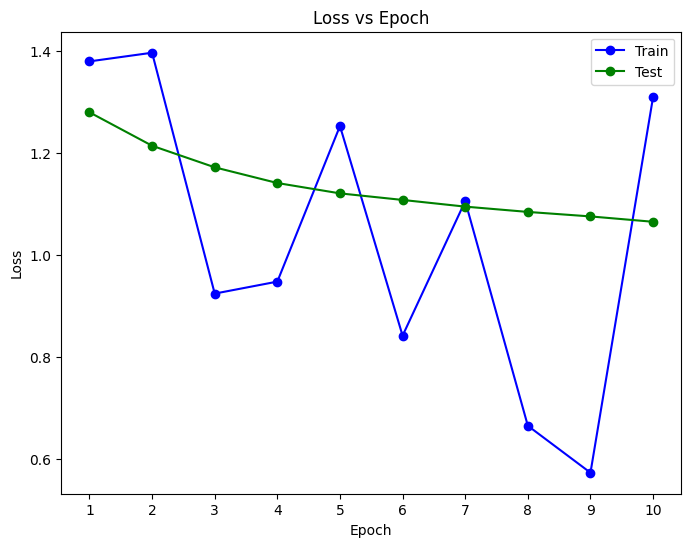

In [ ]:
epoch_list = [epoch+1 for epoch in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

show_learning_curve(train_losses, test_losses, epoch_list)

### Accuracy

In [ ]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

show_accuracy_table(train_accuracies, test_accuracies, epochs)

,Covid Train Accuracy,Covid Test Accuracy,Lung-Opacity Train Opacity Accuracy,Lung-Opacity Test Opacity Accuracy,Normal Train Accuracy,Normal Test Accuracy,Pneumonia Train Accuracy,Pneumonia Test Accuracy
Epoch,,,,,,,,
1,0.144141,0.006916,0.159493,0.078969,0.744420,0.961236,0.158922,0.059480
2,0.006568,0.000000,0.112913,0.158770,0.952293,0.963199,0.041822,0.029740
3,0.003111,0.000000,0.196714,0.268495,0.945180,0.948970,0.026022,0.018587
4,0.002074,0.000000,0.302766,0.359933,0.926784,0.930815,0.026952,0.029740
5,0.000346,0.000000,0.369515,0.423940,0.913417,0.910697,0.030669,0.044610
6,0.001037,0.000000,0.429611,0.453034,0.898209,0.903337,0.049257,0.052045
7,0.000691,0.000000,0.456228,0.489609,0.886436,0.896467,0.073420,0.074349
8,0.000346,0.000000,0.478894,0.509559,0.880549,0.892051,0.115242,0.111524
9,0.001383,0.000000,0.489707,0.523691,0.877729,0.888616,0.156134,0.156134


### Precision

In [ ]:
train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

show_precision_table(train_precisions, test_precisions, epochs)

,Covid Train Precision,Covid Test Precision,Lung-Opacity Train Opacity Precision,Lung-Opacity Test Opacity Precision,Normal Train Precision,Normal Test Precision,Pneumonia Train Precision,Pneumonia Test Precision
Epoch,,,,,,,,
1,0.206028,0.192308,0.357076,0.384615,0.512582,0.497587,0.186275,0.695652
2,0.260274,0.000000,0.405527,0.509333,0.502882,0.510799,0.569620,0.727273
3,0.428571,0.000000,0.455684,0.534768,0.521201,0.534254,0.583333,0.625000
4,0.461538,0.000000,0.487936,0.534568,0.544178,0.556142,0.604167,0.666667
5,0.333333,0.000000,0.500846,0.529046,0.558907,0.571077,0.600000,0.631579
6,0.500000,0.000000,0.505505,0.530672,0.574026,0.578385,0.662500,0.608696
7,0.500000,0.000000,0.508813,0.533998,0.578009,0.589545,0.711712,0.645161
8,0.333333,0.000000,0.512119,0.543440,0.585167,0.593536,0.765432,0.714286
9,0.571429,0.000000,0.522521,0.551664,0.587121,0.597099,0.736842,0.724138


### Recall

In [ ]:
train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

show_recall_table(train_recalls, test_recalls, epochs)

,Covid Train Recall,Covid Test Recall,Lung-Opacity Train Opacity Recall,Lung-Opacity Test Opacity Recall,Normal Train Recall,Normal Test Recall,Pneumonia Train Recall,Pneumonia Test Recall
Epoch,,,,,,,,
1,0.144141,0.006916,0.159493,0.078969,0.744420,0.961236,0.158922,0.059480
2,0.006568,0.000000,0.112913,0.158770,0.952293,0.963199,0.041822,0.029740
3,0.003111,0.000000,0.196714,0.268495,0.945180,0.948970,0.026022,0.018587
4,0.002074,0.000000,0.302766,0.359933,0.926784,0.930815,0.026952,0.029740
5,0.000346,0.000000,0.369515,0.423940,0.913417,0.910697,0.030669,0.044610
6,0.001037,0.000000,0.429611,0.453034,0.898209,0.903337,0.049257,0.052045
7,0.000691,0.000000,0.456228,0.489609,0.886436,0.896467,0.073420,0.074349
8,0.000346,0.000000,0.478894,0.509559,0.880549,0.892051,0.115242,0.111524
9,0.001383,0.000000,0.489707,0.523691,0.877729,0.888616,0.156134,0.156134


### F1-Score

In [ ]:
train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

show_f1_score_table(train_f1_scores, test_f1_scores, epochs)

,Covid Train F1-Score,Covid Test F1-Score,Lung-Opacity Train Opacity F1-Score,Lung-Opacity Test Opacity F1-Score,Normal Train F1-Score,Normal Test F1-Score,Pneumonia Train F1-Score,Pneumonia Test F1-Score
Epoch,,,,,,,,
1,0.169616,0.013351,0.220497,0.131034,0.607121,0.655732,0.171515,0.109589
2,0.012812,0.000000,0.176643,0.242079,0.658190,0.667574,0.077922,0.057143
3,0.006177,0.000000,0.274800,0.357499,0.671897,0.683634,0.049822,0.036101
4,0.004129,0.000000,0.373669,0.430204,0.685722,0.696275,0.051601,0.056940
5,0.000691,0.000000,0.425272,0.470697,0.693482,0.701967,0.058355,0.083333
6,0.002070,0.000000,0.464478,0.488789,0.700426,0.705229,0.091696,0.095890
7,0.001381,0.000000,0.481088,0.510841,0.699743,0.711310,0.133109,0.133333
8,0.000691,0.000000,0.494949,0.525955,0.703094,0.712801,0.200323,0.192926
9,0.002759,0.000000,0.505582,0.537313,0.703598,0.714258,0.257669,0.256881


### Gráfico ROC para cada clase

/tmp/ipykernel_33546/2518052900.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


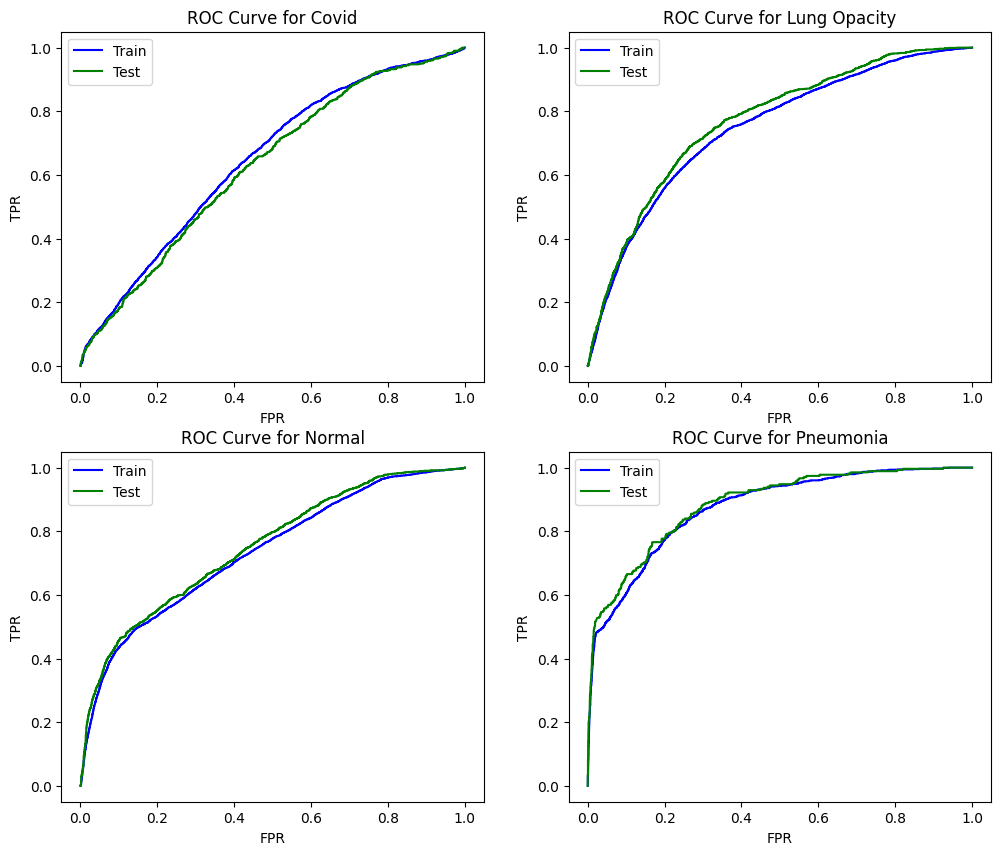

In [ ]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

show_roc_plot(train_roc_fpr, train_roc_tpr, test_roc_fpr, test_roc_tpr)

# Saliency Maps

In [ ]:
unfiltered_cnn_model.eval()

X_test = next(iter(unfiltered_test_dataloader))

num_samples = 4

fig, ax = plt.subplots(2, num_samples, figsize=(16, 8))

for i in range(num_samples):
    current_sample = X_test[0][i]
    
    current_sample.requires_grad_()

    scores = unfiltered_cnn_model(current_sample)

    score_max_index = scores[0].argmax()
    score_max = scores[0, score_max_index.item()]

    score_max.backward()

    X_test_grad = current_sample.grad.abs()

    X_test_grad = X_test_grad.detach().numpy()

    ax[0, i].imshow(current_sample[0].detach().numpy())
    ax[0, i].axis('off')

    img = ax[1, i].imshow(X_test_grad[0], cmap=plt.cm.hot)
    ax[1, i].axis('off')

plt.show()

NameError: name 'unfiltered_cnn_model' is not defined